In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
# from sklearn.neural_network import MLPClassifier
# from sklearn.svm import SVC
import lime
import lime.lime_tabular

# Load pre-processed data

In [16]:
formatted_data = pd.read_csv('data/formatted_data.csv',sep=";")

features = formatted_data.drop(columns=['Target'])
target = formatted_data['Target']

# Model

In [17]:
# Random Seed
RANDOM_SEED = 42

# k-Fold Validation
k = 5
cv = StratifiedKFold(n_splits=k, random_state=RANDOM_SEED, shuffle=True)

## ROC Plotting Function


In [18]:
def plot_roc_curve(fprs, tprs, figsize=(5, 5)):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=figsize)

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)

    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)])
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return fig, ax

In [19]:
def compute_roc_auc(clf, X, y, index):
    y_predict = clf.predict_proba(X.iloc[index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [20]:
def train_and_show_auc(clf, X, y):
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs)
    return clf, pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Training and evaluation

In [21]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_SEED)

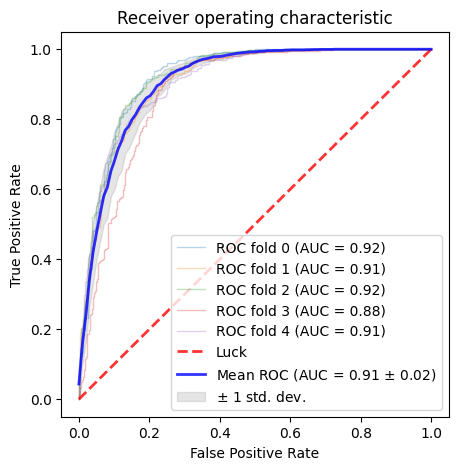

In [22]:
xgb_trained, xgb_scores = train_and_show_auc(xgb_classifier, features, target)

# LIME

In [23]:
# from sklearn.model_selection import train_test_split

# X = formatted_data.drop('Target', axis=1)
# y = formatted_data['Target']

# # Split the data into training and testing sets, stratifying by the target variable
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# # You can print the shape of the train and test sets to verify the split
# print("Train set shape:", X_train.shape, y_train.shape)
# print("Test set shape:", X_test.shape, y_test.shape)

In [24]:
X = formatted_data.drop('Target', axis=1)
y = formatted_data['Target']

# LIME need differentiation between categoriacal and continous variables
categorical_names = ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime_evening_attendance', 
'Previous_qualification', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 
'Mothers_occupation', 'Fathers_occupation', 'Displaced', 'Educational_special_needs', 'Debtor', 
'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International']
categorical_indexes = [X.columns.get_loc(c) for c in categorical_names if c in X]

# Create the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, 
                                                   feature_names=list(features.columns), 
                                                   class_names=['not_selected', 'selected'],
                                                   categorical_features=categorical_indexes,
                                                   categorical_names=categorical_names,
                                                   discretize_continuous=True,
                                                   mode='classification')

In [25]:
VI = np.linalg.inv(np.cov(X.values.T))

In [26]:
# Available distances
distances = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 
             'chebyshev', 'cosine', 'hamming', 'mahalanobis', 'matching', 'minkowski',
             'seuclidean', 'sqeuclidean', 'nan_euclidean']

**Choosing distance**

For mixed data (categorical and numerical features) there is not a clear option for the best distance metric.

For what I read, between the available distances at scikit-learn the manhattan or cityblock distances are most recommended in this case.

Other distances I found and could be interesting to try are:

* HEOM:  Heterogeneous Euclidean-Overlap Metric 
* VDM: Value Difference Metric
* HVDM: Heterogeneous Value Difference Metric
* Gower's Coefficients


References and repositories:
* Improved Heterogeneous Distance Functions: https://arxiv.org/pdf/cs/9701101.pdf
* Distances with Mixed-Type Variables, some Modified Gower’s Coefficient: https://arxiv.org/ftp/arxiv/papers/2101/2101.02481.pdf
* Gower's General Similarity Coefficient: https://www.scribd.com/doc/7343061/Gower-s-Similarity-Coefficient
* https://github.com/KacperKubara/distython
* https://github.com/miriamspsantos/heterogeneous-distance-functions
* https://medium.com/analytics-vidhya/concept-of-gowers-distance-and-it-s-application-using-python-b08cf6139ac2

In [27]:
# Explaining one instance
i = np.random.randint(0, X.shape[0])
i = 18
n = 3
exp = explainer.explain_instance(X.values[i], xgb_trained.predict_proba, num_features=36, top_labels=1, distance_metric=distances[n])
print(f'Distance used: {distances[n]}')
exp.show_in_notebook(show_table=True, show_all=False)

Distance used: manhattan


In [28]:
# from tqdm import tqdm

# # Explain all instances

# df_fi = pd.DataFrame(columns=X.columns)
# df_fi['prediction'] = 0

# for i, instance in tqdm(X.iterrows(), total=X.shape[0]):
    
#     # Explain the instance for the predicted class label
#     exp = explainer.explain_instance(instance.values, xgb_trained.predict_proba, num_features=36, top_labels=1)
#     predicted_class = np.argmax(exp.predict_proba)
    
#     # Feature importances are saved in df_fi
#     feature_importances = {X.columns[f[0]]:f[1] for f in exp.local_exp[predicted_class]}
#     feature_importances['prediction'] = predicted_class
    
#     df_fi.loc[i] = feature_importances

In [29]:
from tqdm import tqdm
# Explain all instances

df_fi = pd.DataFrame(columns=X.columns)
df_fi['prediction'] = 0

for i, instance in tqdm(X.iterrows(), total=X.shape[0]):
    
    feature_importances_sum = {col: 0 for col in X.columns}
    feature_importances_sum['prediction'] = 0

    for _ in range(2):  # Run explainer twice (the feature importances change slightly every time)
        # Explain the instance for the predicted class label
        exp = explainer.explain_instance(instance.values, xgb_trained.predict_proba, num_features=36, top_labels=1, distance_metric="manhattan")
        predicted_class = np.argmax(exp.predict_proba)
        
        # Feature importances are saved in feature_importances_sum
        feature_importances = {X.columns[f[0]]:f[1] for f in exp.local_exp[predicted_class]}
        feature_importances['prediction'] = predicted_class

        for key, value in feature_importances.items():
            feature_importances_sum[key] += value

    # Calculate average feature importances
    feature_importances_avg = {key: value / 2 for key, value in feature_importances_sum.items()}

    df_fi.loc[i] = feature_importances_avg

  0%|          | 0/4424 [00:00<?, ?it/s]

100%|██████████| 4424/4424 [08:53<00:00,  8.29it/s]


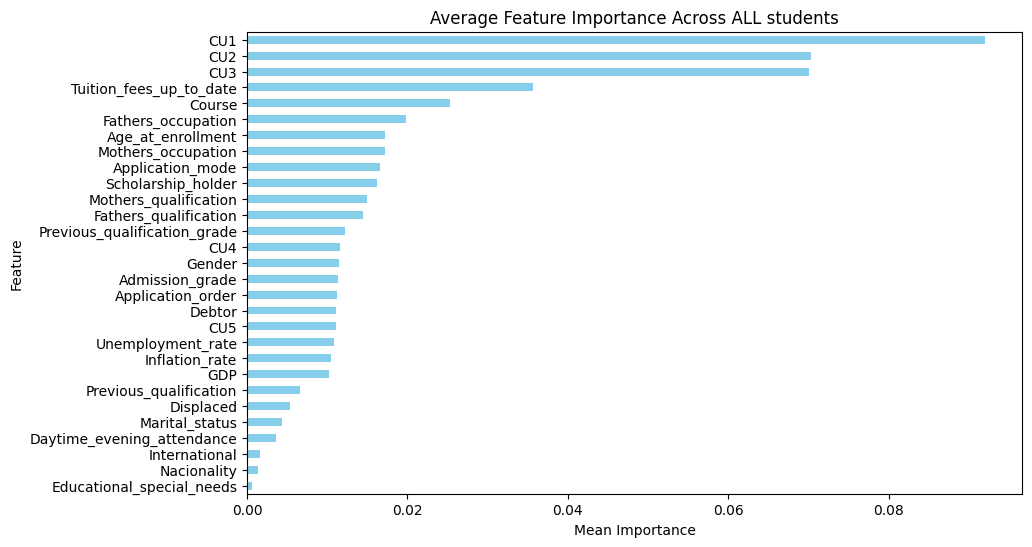

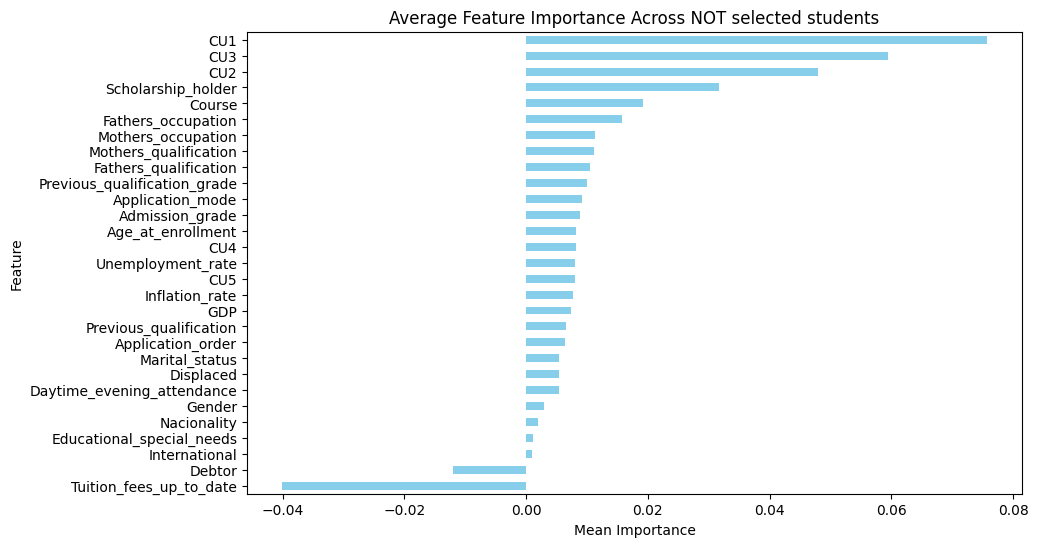

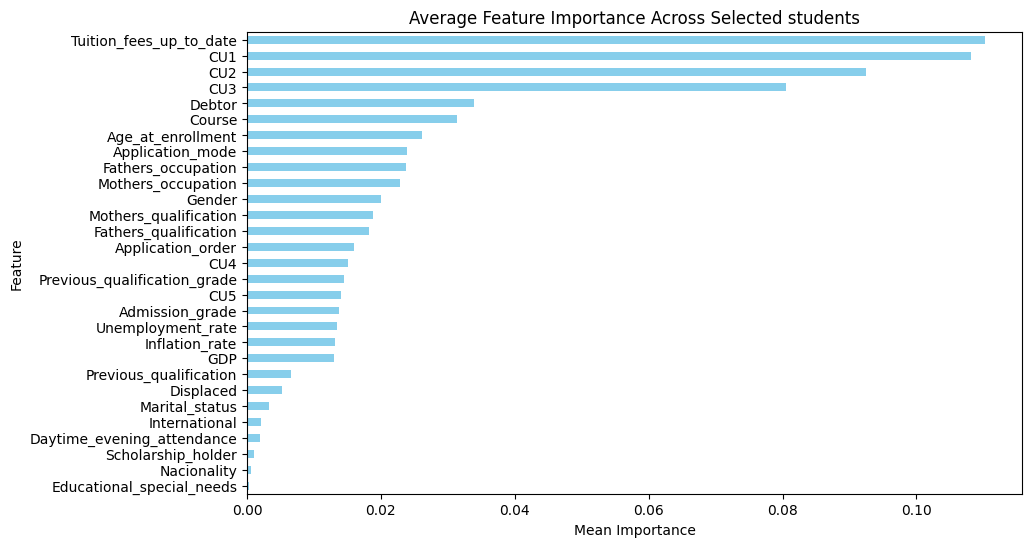

In [30]:
# Calculate the mean feature importance values across all instances
df_0 = X[df_fi['prediction'] == 0]
df_1 = X[df_fi['prediction'] == 1]

df_fi_0 = df_fi[df_fi['prediction'] == 0]
df_fi_1 = df_fi[df_fi['prediction'] == 1]

# Plot the mean feature importance values across all instances
plt.figure(figsize=(10, 6))
df_fi.drop(['prediction'], axis=1).mean().sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across ALL students')
plt.show()

# Plot the mean feature importance values across not selected students
plt.figure(figsize=(10, 6))
df_fi_0.drop(['prediction'], axis=1).mean().sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across NOT selected students')
plt.show()

# Plot the mean feature importance values across selected students
plt.figure(figsize=(10, 6))
df_fi_1.drop(['prediction'], axis=1).mean().sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Selected students')
plt.show()

In [31]:
print(X.columns)

Index(['Marital_status', 'Application_mode', 'Application_order', 'Course',
       'Daytime_evening_attendance', 'Previous_qualification',
       'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification',
       'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation',
       'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
       'Age_at_enrollment', 'International', 'Unemployment_rate',
       'Inflation_rate', 'GDP', 'CU1', 'CU2', 'CU3', 'CU4', 'CU5'],
      dtype='object')


KeyError: 'Curricular_units_2nd_sem_approved'

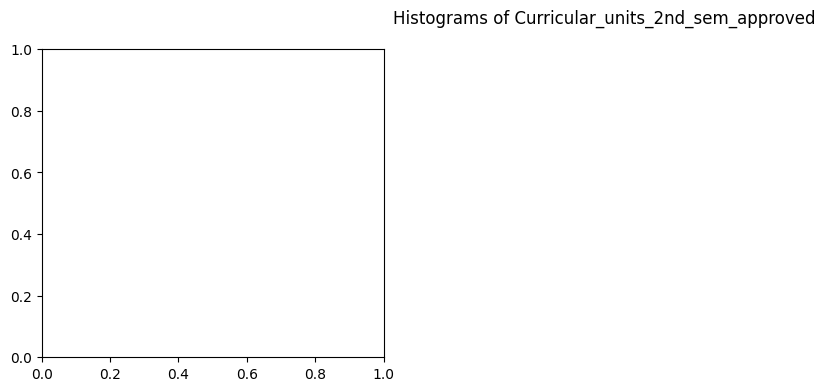

In [32]:

def plot_histograms(feature_name, fig_size=(15,4)):

    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Histograms of {feature_name}")

    plt.subplot(1, 3, 1)
    plt.hist(X[feature_name])
    plt.title("All students")

    plt.subplot(1, 3, 2)
    plt.hist(df_0[feature_name])
    plt.title("NOT selected students")

    plt.subplot(1, 3, 3)
    plt.hist(df_1[feature_name])
    plt.title("Selected students")
    plt.show()

    return

feature = 'Curricular_units_2nd_sem_approved'
plot_histograms(feature)
# for feature in X.columns:
    # plot_histograms(feature)